In [141]:
from keras.models import Model, Sequential
import numpy as np
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import activations, initializers, regularizers, constraints
from keras.utils.conv_utils import conv_output_length
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.initializers import glorot_uniform
from keras.preprocessing import text, sequence
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np 
import pandas as pd 
import os
np.random.seed(0)
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import rcParams
from collections import Counter
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
# Word2vec
import gensim
import time

In [96]:
# WORD2VEC 
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10
# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"
# KERAS
SEQUENCE_LENGTH = 100
BATCH_SIZE = 1024
EPOCHS = 10

### load pre-processed train / test / validation data

In [97]:
X_train = pd.read_csv('./data/X_train.csv')
X_test = pd.read_csv('./data/X_test.csv')
y_train = pd.read_csv('./data/y_train.csv')
y_test = pd.read_csv('./data/y_test.csv')
X_val = pd.read_csv('./data/X_val.csv')
y_val = pd.read_csv('./data/y_val.csv')

In [98]:
X_train = X_train.iloc[:,0]
X_test = X_test.iloc[:,0]
y_train = y_train.iloc[:,0]
y_test = y_test.iloc[:,0]
X_val = X_val.iloc[:,0]
y_val = y_val.iloc[:,0]
X_train

0        worse tea fresh green tea indeed green tea tim...
1        ive tasted best real things wonderful dreadful...
2        love taste good ginger snap cookie saw offered...
3        absolutely love coachs oatmeal hated oatmeal t...
4        normally dont go instant coffees delicious ins...
                               ...                        
96058    ive loved graham crackers since kid many brand...
96059    decided give try since kcup coffee prices goin...
96060    excellent coffee either brewed hot ice drink l...
96061    reading useful negative review times comment t...
96062    excited high protein pretzels opened tasted ta...
Name: text, Length: 96063, dtype: object

In [99]:
print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_val)))
print('Class distribution'+ str(Counter(y_val)))
print('Valid data len:'+str(len(X_test)))
print('Class distribution'+ str(Counter(y_test)))

Train data len:96063
Class distributionCounter({1: 80198, 0: 15865})
Valid data len:32021
Class distributionCounter({1: 26724, 0: 5297})
Valid data len:32022
Class distributionCounter({1: 26731, 0: 5291})


In [100]:
%%time
documents = [_text.split() for _text in X_train] 

Wall time: 1.18 s


In [101]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [102]:
w2v_model.build_vocab(documents)

In [103]:
vocab_size = len(w2v_model.wv)
#vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 14163


In [104]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

Wall time: 1min 19s


(120395507, 133009024)

In [105]:
w2v_model.wv.most_similar("love")

[('adore', 0.5802345871925354),
 ('fantastic', 0.5680603384971619),
 ('loves', 0.5662851333618164),
 ('enjoy', 0.5603818893432617),
 ('wonderful', 0.5557680726051331),
 ('loved', 0.5372111201286316),
 ('awesome', 0.5344123244285583),
 ('amazing', 0.5175678730010986),
 ('great', 0.5149020552635193),
 ('delicious', 0.5119783878326416)]

### vectorize a text corpus, by turning each text into either a sequence of integers using keras oov tokenizer
- num_words : the maximum number of words to keep, based on word frequency. 


In [106]:
#num_words = 50000 #the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

print(str(tokenizer.texts_to_sequences(['coffee pretzel tea'])))

Total words 67497
[[3, 1799, 12]]


In [107]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_val = np.array( tokenizer.texts_to_sequences(X_val) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test) )



x_train = pad_sequences(x_train, padding='post', maxlen=100)
x_val = pad_sequences(x_val, padding='post', maxlen=100)
x_test = pad_sequences(x_test, padding='post', maxlen=100)

c:\users\iambo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
c:\users\iambo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
c:\users\iambo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or 

In [108]:
labels = y_train.unique().tolist()
#labels.append(NEUTRAL)
labels

[0, 1]

In [109]:
encoder = LabelEncoder()
encoder.fit(y_train.tolist())

y_train = encoder.transform(y_train.tolist())
y_test = encoder.transform(y_test.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (96063, 1)
y_test (32022, 1)


In [110]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (96063, 100)
y_train (96063, 1)

x_test (32022, 100)
y_test (32022, 1)


In [111]:
y_train[:10]

array([[0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [112]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(67497, 100)


In [113]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [114]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          6749700   
                                                                 
 dropout_13 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 6,830,201
Trainable params: 80,501
Non-trainable params: 6,749,700
_________________________________________________________________


In [115]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [116]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [117]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
85/85 [==============================] - 165s 2s/step - loss: 0.4516 - accuracy: 0.8304 - val_loss: 0.3341 - val_accuracy: 0.8530 - lr: 0.0010
Epoch 2/10
85/85 [==============================] - 210s 2s/step - loss: 0.3626 - accuracy: 0.8502 - val_loss: 0.2711 - val_accuracy: 0.8926 - lr: 0.0010
Epoch 3/10
85/85 [==============================] - 198s 2s/step - loss: 0.3021 - accuracy: 0.8772 - val_loss: 0.2320 - val_accuracy: 0.9054 - lr: 0.0010
Epoch 4/10
85/85 [==============================] - 191s 2s/step - loss: 0.2608 - accuracy: 0.8938 - val_loss: 0.2112 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 5/10
85/85 [==============================] - 195s 2s/step - loss: 0.2487 - accuracy: 0.8994 - val_loss: 0.2068 - val_accuracy: 0.9188 - lr: 0.0010
Epoch 6/10
85/85 [==============================] - 192s 2s/step - loss: 0.2387 - accuracy: 0.9041 - val_loss: 0.2047 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 7/10
85/85 [==============================] - 193s 2s/step - loss: 0.2

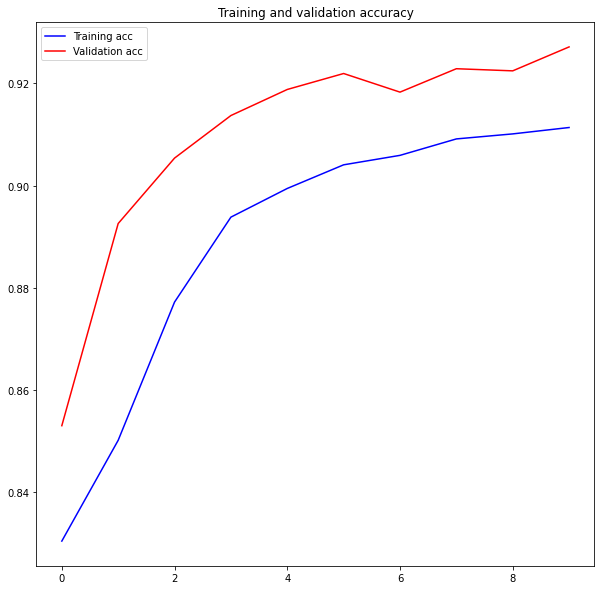

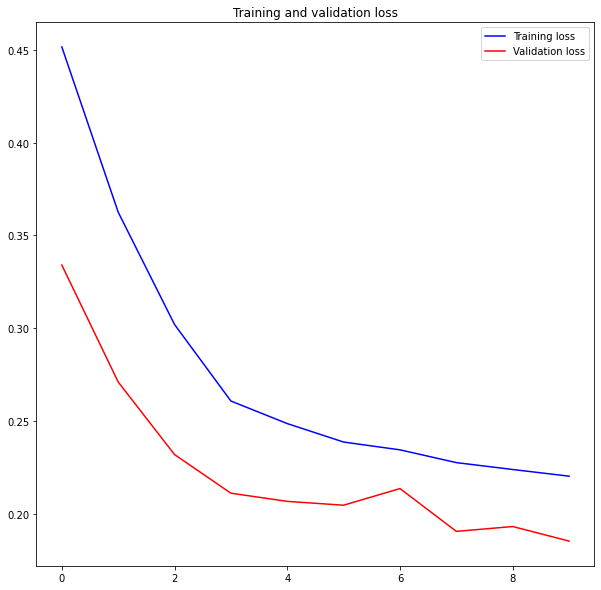

In [120]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [122]:
def decode_sentiment(score):
     return 0 if score < 0.5 else 1

In [124]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [127]:
predict("MPs vote to reject 12 December election plan - but Boris Johnson is likely to try again for a pre-Christmas poll")

{'label': 1, 'score': 0.8829184770584106, 'elapsed_time': 0.37055420875549316}

In [128]:
predict("IS leader Abu Bakr al-Baghdadi was killed in US operation in Syria, President Donald Trump confirms")

{'label': 1, 'score': 0.6643069982528687, 'elapsed_time': 0.07782196998596191}

In [129]:
predict('He was a sick and depraved man, and now he’s gone. Baghdadi was vicious and violent and he died in a vicious and violent way. US President Donald Trump says the “world is now a much safer place” after the killing of IS leader Abu Bakr al-Baghdadi')

{'label': 0, 'score': 0.39946579933166504, 'elapsed_time': 0.07779288291931152}

In [130]:
predict('I bought this property for $1.5 million: Condo resident yells profanities at security guards over visitor parking')

{'label': 1, 'score': 0.6164216995239258, 'elapsed_time': 0.07879042625427246}

In [131]:
%%time
y_pred_1d = []
y_test_1d = list(y_test)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score) for score in scores]

5/5 [==============================] - 9s 2s/step
Wall time: 8.91 s


In [144]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.85      0.66      0.74      5291
           1       0.94      0.98      0.96     26731

    accuracy                           0.92     32022
   macro avg       0.89      0.82      0.85     32022
weighted avg       0.92      0.92      0.92     32022

